# Creating Adversarial Images Using the Carlini-Wagner Attack

## 1. Introduction

Now in this section, we develop a grey-box attack, i.e. one that knows the initial model architecture and training weights. The attack we decided to implement is the Carlini-Wagner L2 attack, first introduced in [Towards Evaluating the Robustness
of Neural Networks](https://arxiv.org/pdf/1608.04644.pdf). This attack uses a loss function which balances the size of perturbation produced against probability of successfully causing a misclassification, to produce adversarial examples which should not be very obvious to the human eye.

To carry out this attack, we use the [cleverhans](https://github.com/cleverhans-lab/cleverhans) library. There are many hyperparameters of the attack to consider, which are explained in the [carlini_wagner_l2.py](https://github.com/cleverhans-lab/cleverhans/blob/master/cleverhans/tf2/attacks/carlini_wagner_l2.py) file. After some investigation into these hyperparameters of the attack, we decided on the following setup. 

We fix the 'initial_const' and 'binary_search_steps' at 1 and 15 respectively; 'initial_const' defines an initial weight on the importance of successfully causing misclassification, and 'binary_search_steps' controls the number of times the algorithm looks for an ideal perturbation which balances perturbation size against misclassification success. These two values seemed to give a good balance between a perturbation being found and the perturbation not being too large.

We create half of the grey-box adversarial test set with a 'learning_rate' of 0.05 and half with 0.2. The learning rate controls how much change is made per search step. The 0.2 value should give a larger perturbation than the 0.05 value. I wanted to include two variations of the algorithm as the defences may be better at dealing with smaller or larger perturbations, and this should test it more thoroughly.

In [1]:
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
import tensorflow as tf
#!pip3 install cleverhans
from cleverhans.tf2.attacks import carlini_wagner_l2

## 2. Investigation
First we load in the test images, as well as the test data labels so that we can compare the predictions to the true class and check everything is as it should be.

In [2]:
img_array = np.load('32_filter_test_data.npy')
labels=np.load('32_filter_test_label.npy')

First we have the code which uses the 'learning_rate' of 0.05. We show how it works on image with index 9 in the test set.

In [3]:
index=9

The Carlini-Wagner attack can be implemented by either supplying the model itself or querying the model to learn about its outputs. From what we discussed about our setting, we will assume that the attackers somehow have access to the original model. So we load that in here.

In [4]:
model = tf.keras.models.load_model('basic_cnn_model_filter.h5')

We now must define a function which returns the model as that is the form that the attack object expects.

In [5]:
def model_fn(x):
    return model(x)

This line of code defines the attack.

In [6]:
attack = carlini_wagner_l2.CarliniWagnerL2(model_fn,initial_const=1,learning_rate=5e-2,binary_search_steps=15)

We now get the image from the image array, put it through a keras preprocessing function to make sure it is in the correct form and then expand to give the image an extra dimension. This is because the attack expects a batch of images, but we are just trying to test it on one currently, so we have to do this to make sure it is in the correct form.

In [7]:
image = tf.keras.preprocessing.image.img_to_array(img_array[index])
image_batch = np.expand_dims(image, axis=0)

Then this is the code to actually run the attack, and we afterwards return it to its original dimensions.

In [8]:
adv_image_batch = attack.attack(image_batch)
adv_image = adv_image_batch[0]

So let's check the predictions of the original image against the adversarial image, as well as the correct class. We also include a check that the adversarial image has changed from the original one, because during my experimenting I found that occasionally the attack cannot find a pertubation and so the image does not change.

In [9]:
adv_prediction = model.predict(tf.expand_dims(adv_image, axis=0))
prediction = model.predict(tf.expand_dims(image, axis=0))
adv_class = tf.argmax(adv_prediction[0])
pred_class = tf.argmax(prediction[0])
print(adv_class)
print(pred_class)
print(labels[index])
print(np.array_equal(image, adv_image))

1/1 [==============================] - 0s 42ms/step
tf.Tensor(37, shape=(), dtype=int64)
tf.Tensor(35, shape=(), dtype=int64)
35
False


We can see that there has successfully been a misclassification of the adversarial image, and it looks like everything else is as it should be. Now we take a look at the output and how obvious the pertubation is to the human eye.

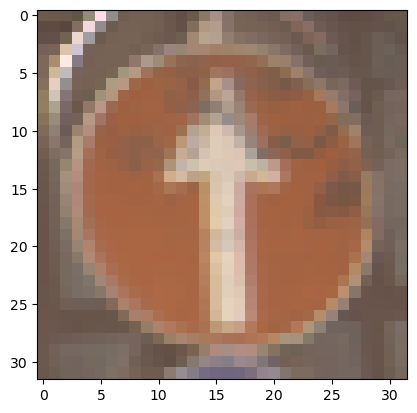

In [10]:
plt.imshow(image)

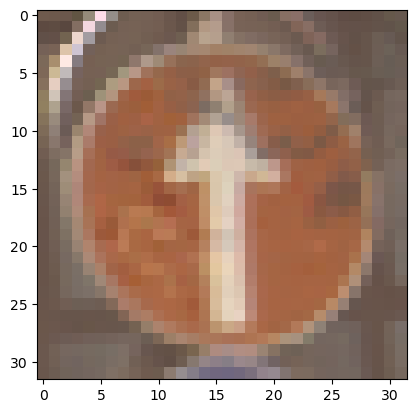

In [11]:
plt.imshow(adv_image)

We can see that the perturbation is definitely visible, so it fits our requirement of being able to physically apply this to road signs. However, it is not too large that it would immediately be noticeable as something trying to cause harm. So overall, this is in the realms of what we were aiming for.

We now check that the attack algorithm is working not just on this example. Here, we test the first 100 images in the test set and see what number of them didn't change.

In [372]:
count=0
for i in range(100):
    index=i
    img_array = np.load('32_filter_test_data.npy')
    model = tf.keras.models.load_model('basic_cnn_model_filter.h5')
    def model_fn(x):
        return model(x)
    attack = carlini_wagner_l2.CarliniWagnerL2(model_fn,initial_const=1,learning_rate=5e-2,binary_search_steps=15)
    image = tf.keras.preprocessing.image.img_to_array(img_array[index])
    image_batch = np.expand_dims(image, axis=0)
    adv_image_batch = attack.attack(image_batch)
    adv_image = adv_image_batch[0]
    adv_prediction = model.predict(tf.expand_dims(adv_image, axis=0))
    prediction = model.predict(tf.expand_dims(image, axis=0))
    adv_class = tf.argmax(adv_prediction[0])
    pred_class = tf.argmax(prediction[0])
    if adv_class == pred_class:
        count+=1

1/1 [==============================] - 0s 24ms/step


In [373]:
print(count)

2


2/100 seems not too bad for failures.

Now let's have a look at what happens when we increase the 'learning_rate' to 0.2.

In [36]:
index=9
img_array = np.load('32_filter_test_data.npy')
model = tf.keras.models.load_model('basic_cnn_model_filter.h5')
def model_fn(x):
    return model(x)
attack = carlini_wagner_l2.CarliniWagnerL2(model_fn,initial_const=1,learning_rate=2e-1,binary_search_steps=15)
image = tf.keras.preprocessing.image.img_to_array(img_array[index])
image_batch = np.expand_dims(image, axis=0)
adv_image_batch = attack.attack(image_batch)
adv_image = adv_image_batch[0]
adv_prediction = model.predict(tf.expand_dims(adv_image, axis=0))
prediction = model.predict(tf.expand_dims(image, axis=0))
adv_class = tf.argmax(adv_prediction[0])
pred_class = tf.argmax(prediction[0])
print(adv_class)
print(pred_class)
print(labels[index])
print(np.array_equal(image, adv_image))

1/1 [==============================] - 0s 46ms/step
tf.Tensor(37, shape=(), dtype=int64)
tf.Tensor(35, shape=(), dtype=int64)
35
False


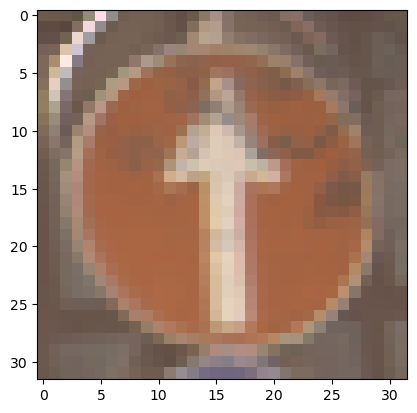

In [37]:
plt.imshow(image)

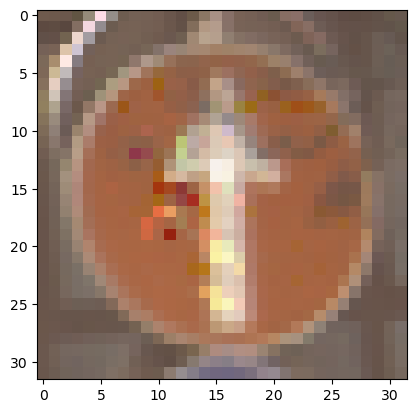

In [38]:
plt.imshow(adv_image)

This definitely produces a different style of perturbation, so we will use this for half of the test set to give some variety.

## 3. Test Set Generation

Each adversarial image creation takes a few minutes so we will need to parallelise the generation of 12630 of them. I will now split into into batches to run on the HPC. I will do 421 batches since we have:

In [52]:
len(img_array)/30

421.0

We will do 211 batches of the 0.05 learning rate and 210 batches of the 0.2 learning rate as we don't require them to be equal. This means we will produce 6330 with learning rate 0.05.

In [105]:
30*211

6330

So each batch will be 30 images long. Each image takes less than 10 minutes to complete so each batch will take less than 300 minutes which equals 5 hours. So we can set a limit of 5 hours on each batch. We will just do a run through below of a batch of two to demonstrate.

In [109]:
batch_size=2
index=1
adv_img_array=np.zeros((batch_size,32,32,3))
for i in range(batch_size):
    attack = carlini_wagner_l2.CarliniWagnerL2(model_fn,initial_const=1,learning_rate=2e-1,binary_search_steps=15)
    current_index=(index-1)*batch_size+i
    image = tf.keras.preprocessing.image.img_to_array(img_array[current_index])
    image_batch = np.expand_dims(image, axis=0)
    adv_image_batch = attack.attack(image_batch)
    adv_img_array[i] = adv_image_batch[0]

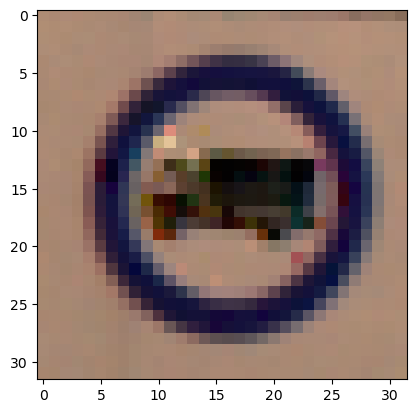

In [110]:
plt.imshow(adv_img_array[0])

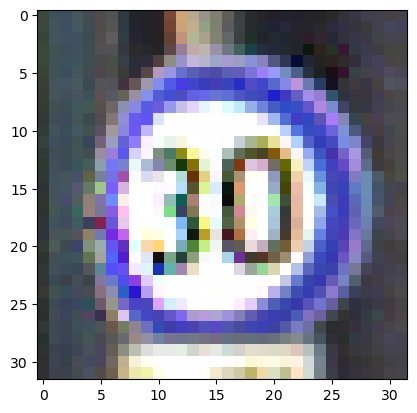

In [111]:
plt.imshow(adv_img_array[1])

Just to check we have our indices correct, we look at the corresponding images in the original array.

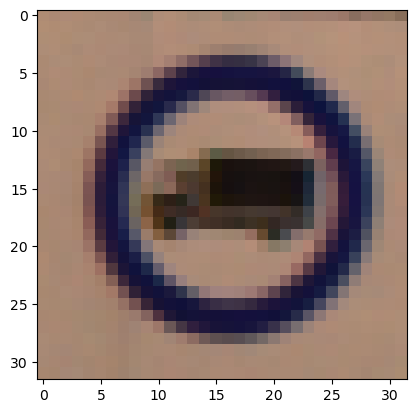

In [112]:
plt.imshow(img_array[0])

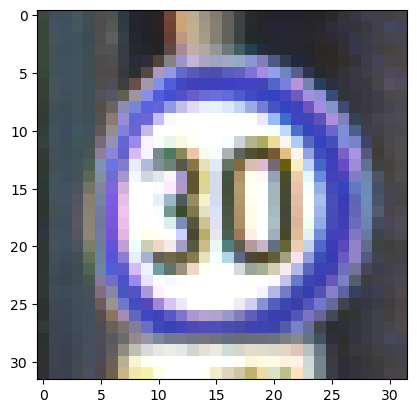

In [113]:
plt.imshow(img_array[1])

Finally, we save the file, adding the index at the front so we can then easily combine them after the creation of them is complete.

In [ ]:
file_name = str(index) + "_adv_batch_trial.npy"
np.save(file_name, adv_img_array)

Below we show the datasets obtained from the HPC, which can be found on google drive.

In [143]:
cw_advs_005 = np.load('005_cw_advs.npy')
cw_advs_02 = np.load('02_cw_advs.npy')

In [144]:
cw_advs_005.shape

(6330, 32, 32, 3)

In [142]:
cw_advs_02.shape

(6300, 32, 32, 3)

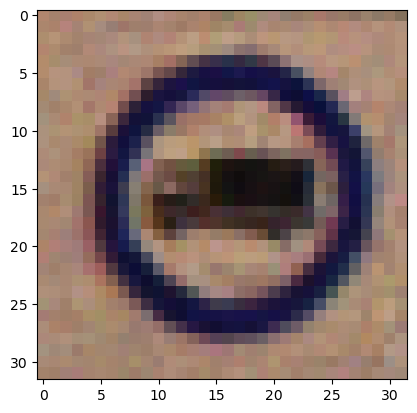

In [145]:
plt.imshow(cw_advs_005[0])

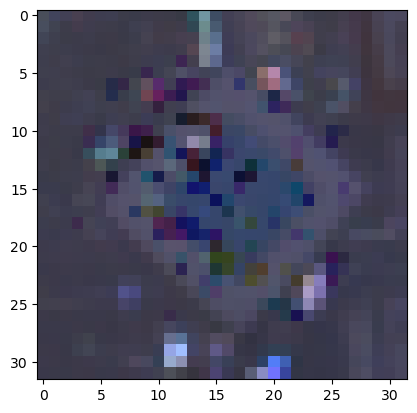

In [146]:
plt.imshow(cw_advs_02[0])